In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import mech_io
from pathlib import Path
%matplotlib inline

In [2]:
db = Path(os.path.abspath('')) / "data" / "database" / "2021-02-18_mech_db.db"

In [3]:
yearly_query = """SELECT strftime('%Y', topic_created) AS year, 
                         COUNT('td.topic_id') AS 'group buys', 
                         AVG(views), 
                         AVG(replies)
                  FROM topic_data AS td LEFT JOIN topic_advanced AS ta
                      ON td.topic_id = ta.topic_id
                  WHERE product_type = 'keycaps' AND board = '70'
                  GROUP BY strftime('%Y', topic_created)
                  ;"""
# yearly_df = pd.DataFrame(mech_io.db_query(yearly_query, db))

conn = sqlite3.connect(db)
yearly_df = pd.read_sql_query(yearly_query, conn)
conn.close()

In [4]:
yearly_df.head(10)

,year,group buys,AVG(views),AVG(replies)
0,2012,6,27542.833333,146.666667
1,2013,19,270136.263158,795.105263
2,2014,11,342704.454545,833.636364
3,2015,16,914333.062500,1318.750000
4,2016,25,126034.880000,306.920000
5,2017,38,27294.052632,134.157895
6,2018,48,43862.708333,211.333333
7,2019,90,59574.600000,151.522222
8,2020,149,27166.154362,61.570470
9,2021,27,9008.074074,27.074074


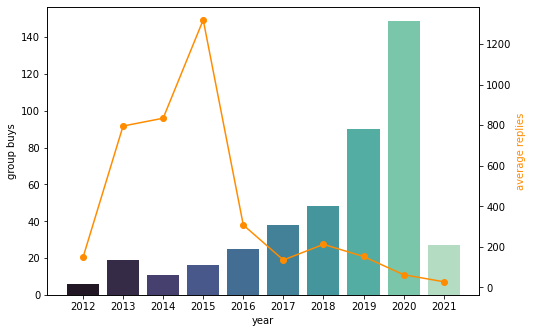

In [5]:
yearly_plot = plt.figure()
yearly_ax1 = yearly_plot.add_axes([1, 1, 1, 1])
sns.barplot(data=yearly_df, x='year', y='group buys', palette='mako', ax=yearly_ax1)
yearly_ax2 = yearly_ax1.twinx()
yearly_ax2.set_ylabel('average replies', color='darkorange')
yearly_ax2.plot(yearly_df['year'], yearly_df['AVG(replies)'], marker='o', color='darkorange')

In this graph, even though the number of group buys shows a massive increase year over year - the average number of replies has consistently decreased.
Partially this can be explained by a larger number of "chaff" gbs that fail to go into production - but the larger part of the story is probably moving from purchasing happening on the forum itself to purchases at spcific regional vendors and proxies (so the change in average replies represents the geekhack threads being used more as an archive or hub vs a place for actual discussion and purchases).

In [19]:
monthly2020_query = """SELECT strftime('%m %Y', topic_created) AS month, 
                         COUNT('td.topic_id') AS 'group buys', 
                         AVG(views), 
                         AVG(replies)
                  FROM topic_data AS td LEFT JOIN topic_advanced AS ta
                      ON td.topic_id = ta.topic_id
                  WHERE product_type = 'keycaps' AND board = '70' 
                      AND (strftime('%Y', topic_created) IN ('2017', '2018', '2019', '2020'))
                  GROUP BY strftime('%Y %m', topic_created)
                  ;"""

conn = sqlite3.connect(db)
monthly2020_df = pd.read_sql_query(monthly2020_query, conn)
conn.close()

In [20]:
monthly2020_df.head()

,month,group buys,AVG(views),AVG(replies)
0,01 2017,2,117776.000000,715.500000
1,02 2017,3,24146.333333,117.333333
2,03 2017,4,18398.250000,85.750000
3,04 2017,2,11969.500000,62.500000
4,05 2017,2,11155.500000,29.500000


In [34]:
monthly_rolling = monthly2020_df['group buys'].rolling(3).mean()
monthly_rolling.head()

0         NaN
1         NaN
2    3.000000
3    3.000000
4    2.666667
Name: group buys, dtype: float64

<AxesSubplot:ylabel='group buys'>

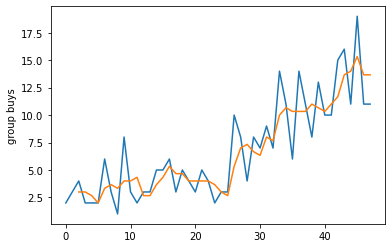

In [35]:
monthly2020_plot, monthly2020_ax1 = plt.subplots()
sns.lineplot(data=monthly2020_df['group buys'], palette='mako', ax=monthly2020_ax1)
sns.lineplot(data=monthly_rolling, palette='mako', ax=monthly2020_ax1)
# sns.regplot(x=monthly2020_df.index, y=monthly2020_df['group buys'], order=2, ax=monthly2020_ax1)
# plot two different linear regressions based on the year?

In [37]:
gbvsic_query = """SELECT gb.topic_id as 'group buy',
                     ic.topic_id as 'interest check',
                     gb.set_name as 'set name',
                     gb.views as 'group buy views',
                     ic.views as 'interest check views',
                     gb.replies as 'group buy replies',
                     ic.replies as 'interest check replies',
                     strftime('%Y', ta.topic_created) as 'group buy year'
              FROM topic_data AS gb INNER JOIN topic_data AS ic
                  ON gb.set_name = ic.set_name
                  AND gb.board = '70'
                  AND ic.board = '132'
              LEFT JOIN topic_advanced AS ta
                      ON gb.topic_id = ta.topic_id
              WHERE gb.product_type = 'keycaps'
              ;"""

conn = sqlite3.connect(db)
gbvsic_df = pd.read_sql_query(gbvsic_query, conn)
conn.close()

In [38]:
gbvsic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   group buy               305 non-null    object
 1   interest check          305 non-null    object
 2   set name                305 non-null    object
 3   group buy views         305 non-null    int64 
 4   interest check views    305 non-null    int64 
 5   group buy replies       305 non-null    int64 
 6   interest check replies  305 non-null    int64 
 7   group buy year          305 non-null    object
dtypes: int64(4), object(4)
memory usage: 19.2+ KB


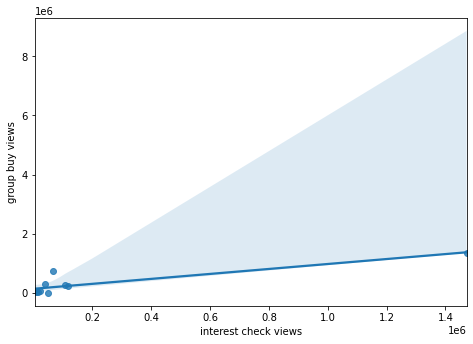

In [39]:
gbvsic_plot = plt.figure()
gbvsic_ax1 = gbvsic_plot.add_axes([1, 1, 1, 1])
sns.regplot(data=gbvsic_df[gbvsic_df['group buy year'].isin(['2012', '2013', '2014', '2015'])], x='interest check views', y='group buy views', ax=gbvsic_ax1)
# gbvsic_ax1.set_xlim(xmin= 0, xmax=200000)
# gbvsic_ax1.set_ylim(ymin = 0, ymax=200000)

ModuleNotFoundError: No module named 'statsmodels'

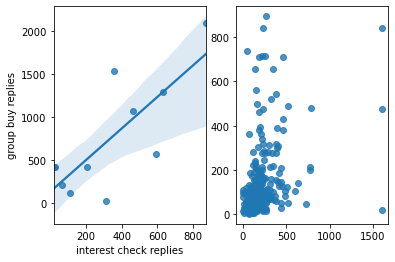

In [42]:
gbvsic2_plot, (gbvsic2_ax1, gbvsic2_ax2) = plt.subplots(1, 2)
# gbvsic2_ax1 = gbvsic2_plot.add_axes([1, 1, 1, 1])
sns.regplot(data=gbvsic_df[gbvsic_df['group buy year'].isin(['2012', '2013', '2014', '2015'])], x='interest check replies', y='group buy replies', ax=gbvsic2_ax1)
# gbvsic2_ax1.set_xlim(xmin= 0, xmax=750)
# gbvsic2_ax1.set_ylim(ymin = 0, ymax=750)
sns.regplot(data=gbvsic_df[gbvsic_df['group buy year'].isin(['2016', '2017', '2018', '2019', '2020', '2021'])], x='interest check replies', y='group buy replies', robust=True, ax=gbvsic2_ax2)